In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
import missingno
from konlpy.tag import Okt, Hannanum, Mecab
import re
from tqdm import tqdm, trange
import pickle
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer

ma = Okt()

In [4]:
# crawl to db
con = sqlite3.connect('../news_Crawl.db')
cur = con.cursor()

In [1]:
# con.close()

NameError: name 'con' is not defined

In [5]:
cur.execute('''
    SELECT id, title, content, category, dateNews FROM news WHERE content != '';
''')
articles = cur.fetchall()

In [6]:
len(articles)

(156127, (159929,))

In [8]:
articles = pd.DataFrame(articles)

In [10]:
articles.head(10)

,0,1,2,3,4
0,AKR20221207132500001,"""이태원참사 다음날 대통령 주재 회의서 &apos압사&apos 빼라 지시 나와""",(서울=연합뉴스) 조민정 박경준 기자 = 이태원 압사 참사 다음 날 윤석열 대통령...,정치,221207132
1,AKR20221207135900051,"[부산 대학가 소식] 동의대 부속 동의어린이집, 보육공모전 우수상","[동의대 제공] 수근종합건설, 동아대 경영대학원 장학기금 3억원 조성 (부산=연합뉴...",사회,221207135
2,AKR20221207133900111,"&aposUAE 우주포럼&apos 첫 회의, ""패권 경쟁보다 협력"" 강조하며 폐막",(아부다비=연합뉴스) 이승민 특파원 = '아부다비 스페이스 디베이트 포럼'(ADS...,국제,221207133
3,AKR20221207111000009,"대만 TSMC, 미국서 4나노 2024년·3나노 2026년 생산 시작",(타이베이=연합뉴스) 김철문 통신원 = 세계 최대 파운드리(반도체 위탁생산) 업체...,국제,221207111
4,AKR20221207123800009,"러 전직 장관이 우크라 농지 싹쓸이…""뉴욕시 면적 2배""",(서울=연합뉴스) 오진송 기자 = 러시아 전직 장관이 민간인 신분으로 우크라이나 ...,국제,221207123
5,AKR20221207134500053,"진화에만 2시간…소방당국, 전기차 화재 대응에 골머리",(영주=연합뉴스) 김선형 기자 = 사람이 탑승한 전기차 화재에 마땅한 구조 방법이...,사건사고,221207134
6,AKR20221207128100805,[여행소식] 해외 명품 아웃렛 잇달아 한국 시장 공략,맥아더글렌 디자이너 아웃렛 한국 사무소 개소 10주년 기념식 [사진/성연재 기자] ...,경제,221207128
7,AKR20221207135600054,"한국마이크로소프트 혁신허브, 전남대서 개소…""스타트업 지원""","(광주=연합뉴스) 손상원 기자 = 중소기업, 스타트업을 지원하는 '한국마이크로소프...",사회,221207135
8,AKR20221206140251004,중랑구에 &apos서울형 키즈카페&apos 2호점…놀이기구 14종 구비(종합),(서울=연합뉴스) 김준태 기자 = 서울시는 중랑구에 '서울형 키즈카페' 2호점을 ...,사회,221206140
9,AKR20221207124700001,"대통령실 ""일많은데 무슨 한동훈 차출이냐? 그게 尹대통령 생각""",(서울=연합뉴스) 정아란 한지훈 기자 = 윤석열 대통령이 여당 전당대회를 앞두고 ...,정치,221207124


In [11]:
articles[3].describe()

count     156127
unique        13
top           정치
freq       32974
Name: 3, dtype: object

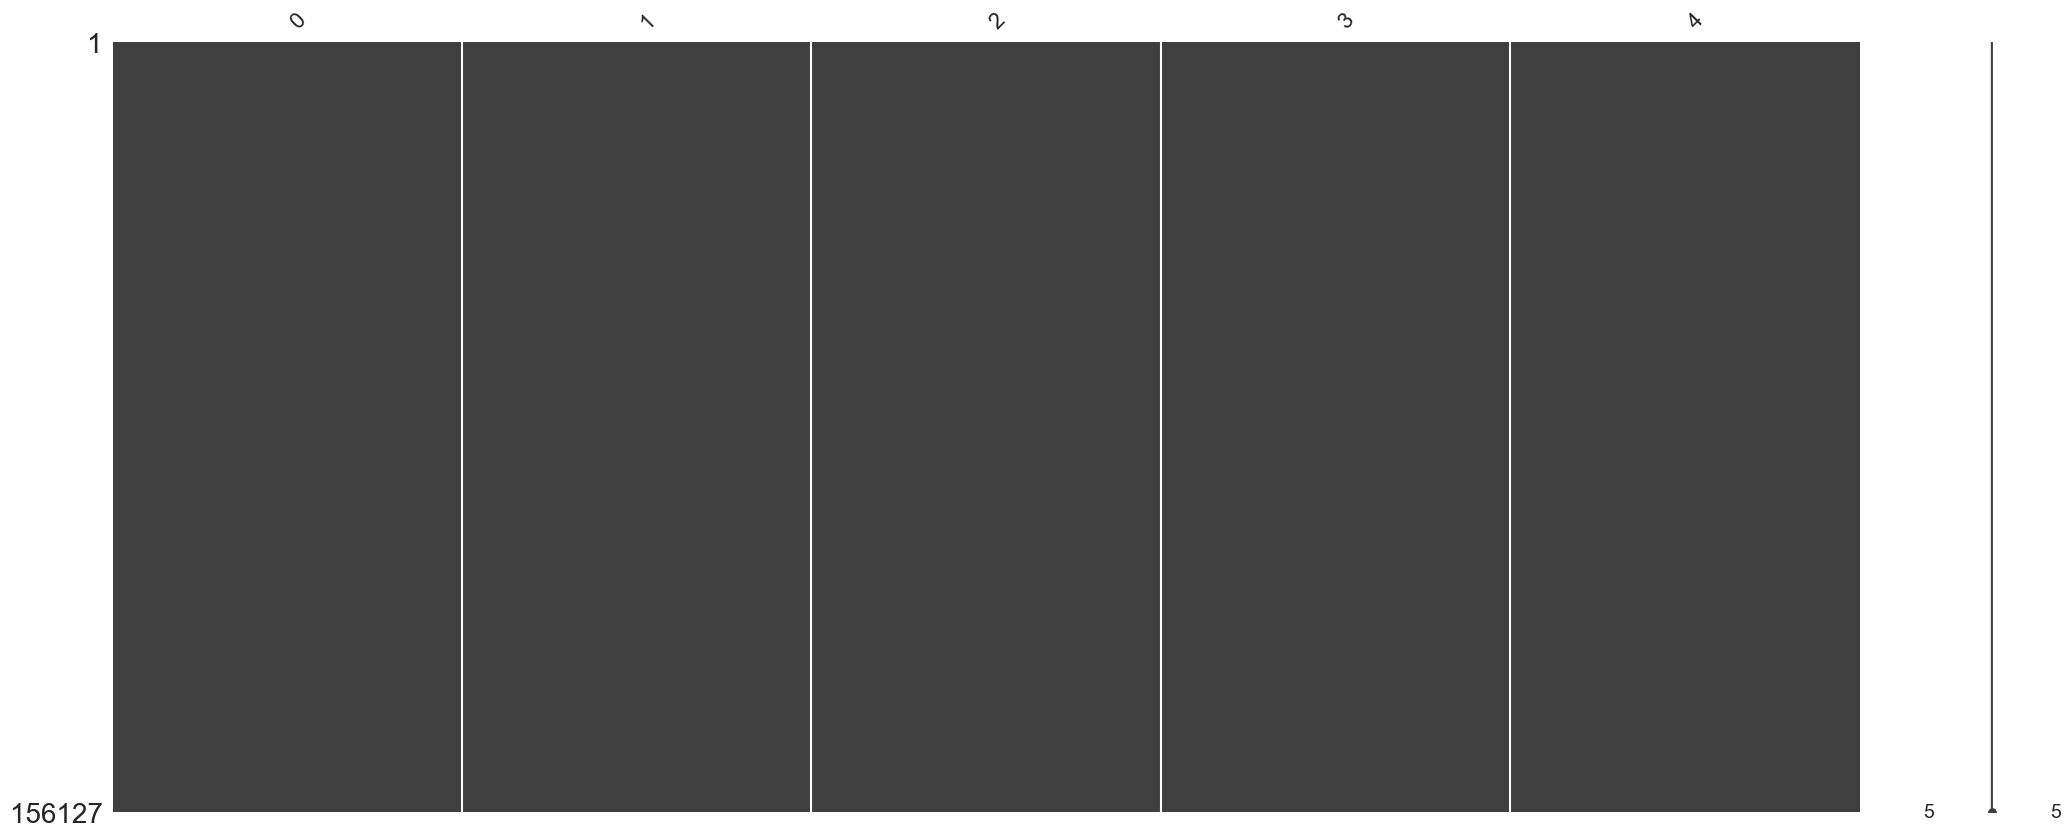

In [12]:
missingno.matrix(articles)
plt.show()

In [23]:
articles[4] = articles[4].apply(lambda x: str(x)[:6])
articles[4].value_counts()
# plt.hist(articles[3])
# plt.show()

221207    958
221206    829
221205    820
220127    664
220602    637
         ... 
210928      1
211012      1
201015      1
211016      1
211018      1
Name: 4, Length: 405, dtype: int64

In [26]:
# 전처리
articles[5] = articles[2].apply(lambda x: re.sub('[^0-9A-Za-zㄱ-ㅎㅏ-ㅣ가-힣 ]', ' ', x))
articles[5] = articles[5].apply(lambda x: re.sub(r'\s{2,}', ' ', x))
articles[5] = articles[5].apply(lambda x: ma.phras(x))
corpus = articles[5].apply(lambda x: ' '.join(x))
corpus.head(10)

0      서 울   연 합 뉴 스   조 민 정   박 경 준   기 자   이 태 원 ...
1      동 의 대   제 공   수 근 종 합 건 설   동 아 대   경 영 대 학 ...
2      아 부 다 비   연 합 뉴 스   이 승 민   특 파 원   아 부 다 비 ...
3      타 이 베 이   연 합 뉴 스   김 철 문   통 신 원   세 계   최 ...
4      서 울   연 합 뉴 스   오 진 송   기 자   러 시 아   전 직   ...
5      영 주   연 합 뉴 스   김 선 형   기 자   사 람 이   탑 승 한 ...
6    맥 아 더 글 렌   디 자 이 너   아 웃 렛   한 국   사 무 소   개 ...
7      광 주   연 합 뉴 스   손 상 원   기 자   중 소 기 업   스 타 ...
8      서 울   연 합 뉴 스   김 준 태   기 자   서 울 시 는   중 랑 ...
9      서 울   연 합 뉴 스   정 아 란   한 지 훈   기 자   윤 석 열 ...
Name: 5, dtype: object

In [73]:
CV = CountVectorizer()
x = CV.fit_transform(corpus)
tfid = TfidfTransformer(sublinear_tf=True)
x = tfid.fit_transform(x)
# corpus

In [74]:
# TF-IDF - 어떻게 해석해야 하는가
pipe = Pipeline([('count', CountVectorizer()),
                 ('tfidf', TfidfTransformer(sublinear_tf=True))]).fit_transform(corpus)

In [76]:
with open('news_TFIDF.pickle', 'wb') as f:
    pickle.dump(pipe, f)

In [32]:
# stopwords = stopwords.split()

In [33]:
# with open('stopwords.pickle', 'wb') as f:
#     pickle.dump(stopwords, f)

In [ ]:
# remove stopwords
